In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
seq_exp = np.load("seq_exp.npy")
seq_real = np.load("seq_real.npy")

In [3]:
zt_freqs = cp.linspace(-90e3, 30e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6
print(zt_rabi * zt_pulse)

0.505


### Check co-prop, set $\eta=0$

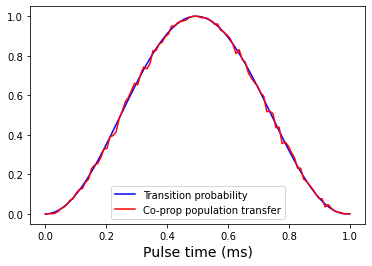

In [4]:
from cu_rsc.RSC_functions import excecute_single_raman_pulse
from cu_rsc.RSC_functions import rabi_transition_prob
freqs = cp.array([0])
zt_times = np.linspace(0, 1e-3, 100)
probs = rabi_transition_prob(2*cp.pi*zt_rabi*cp.ones(100), cp.zeros(100), cp.array(zt_times))
pols = np.zeros(len(zt_times))
temp = [25e-6, 25e-6, 25e-6]

for i, time in enumerate(zt_times):
    mol = cr.build_thermal_molecules_gpu(1_000, temp)
    excecute_single_raman_pulse(
        mol,
        axis=2,
        d_n=0,
        Omega_lin=zt_rabi,
        t_sec=time,
        res=res,
        LD_raman_vec=cp.array([0, 0, 0]),
        detuning_ang=cp.array([0,0,0]),
        Rabi_scale=1.0,
        k_max=0
    )
    # Count molecules in the mN=-1 state
    pols[i] = cp.count_nonzero((mol[:, 3] == -1) & (mol[:, 5] == 0)).get()


fig, ax = plt.subplots()
ax.plot(zt_times*1e3, probs.get(), label='Transition probability', color='blue')
ax.plot(zt_times*1e3, pols/1000, label='Co-prop population transfer', color='red')
ax.set_xlabel("Pulse time (ms)", fontsize=14)
ax.legend()

### RST

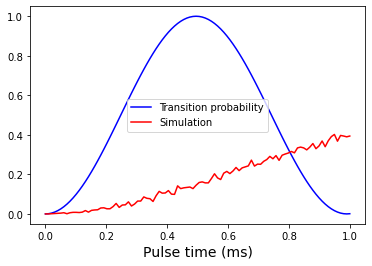

In [5]:
freqs = cp.array([0])
zt_times = np.linspace(0, 1e-3, 100)
probs = rabi_transition_prob(2*cp.pi*zt_rabi*cp.ones(100), cp.zeros(100), cp.array(zt_times))
pols = np.zeros(len(zt_times))
temp = [25e-6, 25e-6, 25e-6]

for i, time in enumerate(zt_times):
    mol = cr.build_thermal_molecules_gpu(1_000, temp)
    frequencys, polarizations = cr.raman_sideband_thermometry(
        molecules_dev=mol,
        axis=2,
        frequencys=cp.array([0]),
        rabi_freq=zt_rabi,
        pulse_time=time,
        res=res,
        k_max=2,
        show_progress=False
    )
    pols[i] = polarizations[0]


fig, ax = plt.subplots()
ax.plot(zt_times*1e3, probs.get(), label='Transition probability', color='blue')
ax.plot(zt_times*1e3, pols/1000, label='Simulation', color='red')
ax.set_xlabel("Pulse time (ms)", fontsize=14)
ax.legend()

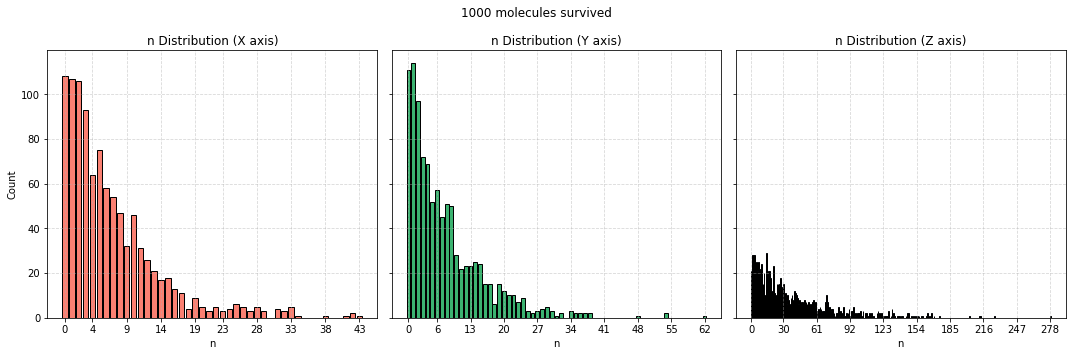

Raman thermometry: 100%|██████████| 1000/1000 [00:15<00:00, 65.47it/s]


In [6]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=10)

frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

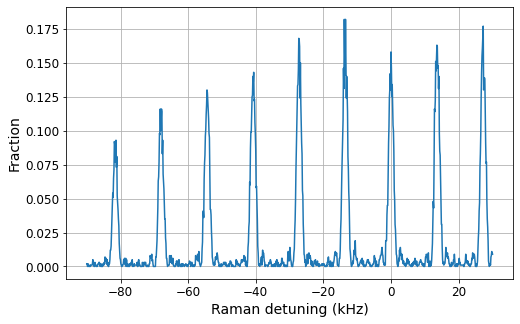

In [7]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

Raman pulses: 100%|██████████| 280/280 [00:36<00:00,  7.77it/s]


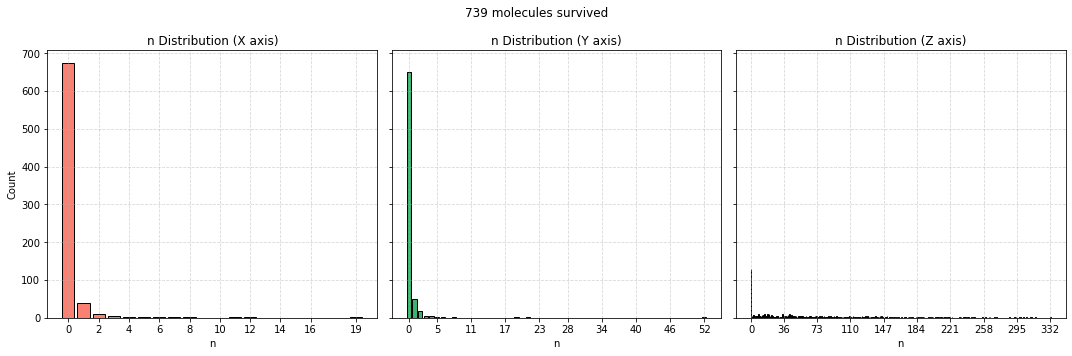

survival_rate_mean 0.739
mot_mean [ 0.22733424  0.33152909 69.29364005]
mot_sem [0.00144647 0.00272398 0.08293199]
Ground state rate 0.12690355329949238


In [8]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
cr.raman_cool_with_pumping(
    mol_0, 
    seq_exp, 
    res, 
    show_progress=True, 
    Detuning=(0, 0, 0),
    k_max=2,)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=10)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])
print("Ground state rate", result['ground_state_rate_mean'])

In [9]:
frequencys, polarizations_cold = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:15<00:00, 65.57it/s]


Raman pulses: 100%|██████████| 280/280 [00:39<00:00,  7.13it/s]


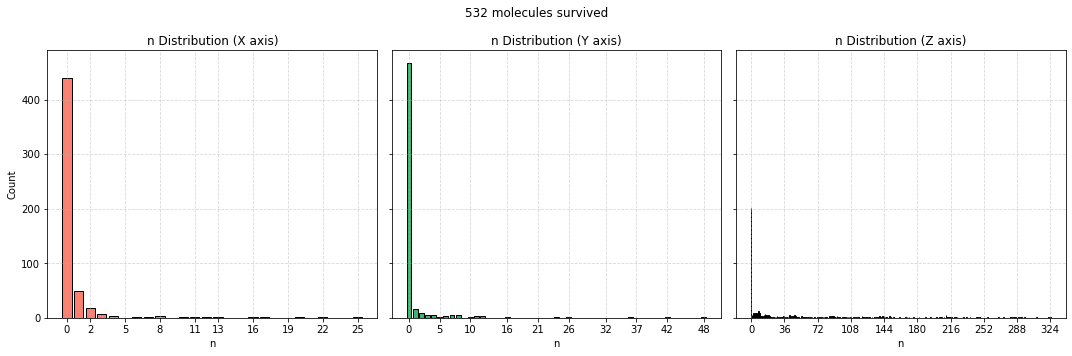

survival_rate_mean 0.532
mot_mean [ 0.59210526  0.86654135 51.37218045]
mot_sem [0.0033755  0.00560384 0.10271297]
Ground state rate 0.2209051724137931


In [10]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
cr.raman_cool_with_pumping(
    mol_0, 
    seq_real, 
    res, 
    show_progress=True, 
    Detuning=(0, 0, 0),
    k_max=2,)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=10)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])
print("Ground state rate", result['ground_state_rate_mean'])

In [11]:
frequencys, polarizations_opt = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:15<00:00, 63.84it/s]


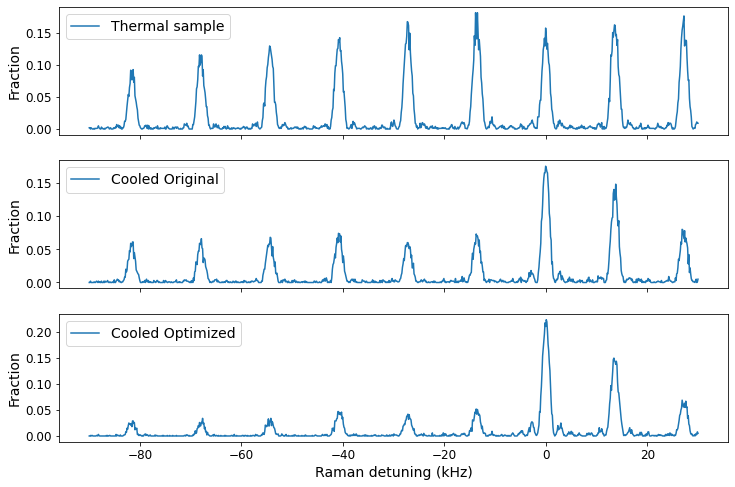

In [12]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
ax[0].plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000, label='Thermal sample')
ax[0].legend(fontsize=14)
ax[1].plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations_cold)/1000, label='Cooled Original')
ax[1].legend(fontsize=14)
ax[2].plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations_opt)/1000, label='Cooled Optimized')
ax[2].legend(fontsize=14)
ax[2].set_xlabel("Raman detuning (kHz)", fontsize=14)
ax[0].set_ylabel("Fraction", fontsize=14)
ax[1].set_ylabel("Fraction", fontsize=14)
ax[2].set_ylabel("Fraction", fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[2].tick_params(axis='both', which='major', labelsize=12)

### Vary trap detuning

In [4]:
trap_dets = np.linspace(-2e3, 2e3, 5)
mol_0 = cr.build_thermal_molecules_gpu(1000, [25e-6, 25e-6, 25e-6])
fractions = []
for det in trap_dets:
    frequencys, pol = cr.raman_sideband_thermometry(
        molecules_dev=mol_0,
        axis=2,
        frequencys=zt_freqs,
        rabi_freq=zt_rabi,
        pulse_time=zt_pulse,
        res=res,
        k_max=2,
        trap_detuning=(0, 0, det)
    )
    fractions.append(pol)

Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 62.42it/s]


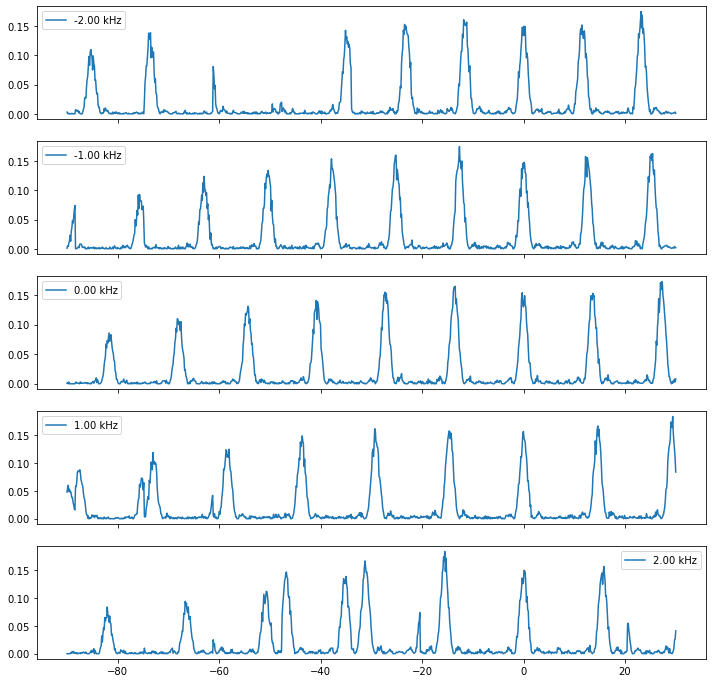

In [5]:
fig, ax = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
for i, det in enumerate(trap_dets):
    ax[i].plot(frequencys.get()/1000, fractions[i].get()/1000, label=f"{det/1e3:.2f} kHz")
    ax[i].legend()